<a href="https://colab.research.google.com/github/sawesky/deep-stegano/blob/masterpsnrlinnaeus5/Diplomski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar

--2023-05-29 17:15:50--  http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar
Resolving chaladze.com (chaladze.com)... 74.208.236.157, 2607:f1c0:100f:f000::25c
Connecting to chaladze.com (chaladze.com)|74.208.236.157|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138983573 (133M) [application/rar]
Saving to: ‘Linnaeus 5 128X128.rar’

Linnaeus 5 128X128. 100%[===================>] 132.54M  43.2MB/s    in 3.2s    

2023-05-29 17:15:53 (41.2 MB/s) - ‘Linnaeus 5 128X128.rar’ saved [138983573/138983573]



In [2]:
!unrar x "/content/Linnaeus 5 128X128.rar"

Streaming output truncated to the last 5000 lines.
Extracting  Linnaeus 5 128X128/train/berry/825_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/826_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/827_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/828_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/829_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/82_128.jpg                     38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/830_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/831_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/832_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/833_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X12

In [3]:
!pip install Keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.utils as image #mora da se doda da prekrsi preprocessing image 
import keras.backend as K

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [11]:
### Constants ###
DATA_DIR = "./Linnaeus 5 128X128"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (128, 128)

In [12]:
def load_dataset_small(num_images_per_class_train=400, num_images_test=50):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c)
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    for test in os.listdir(TEST_DIR):
        test_dir = os.path.join(TEST_DIR, test)
        test_imgs = os.listdir(test_dir)
        random.shuffle(test_imgs)
        for img_name_i in test_imgs[0:num_images_test]:
            img_i = image.load_img(os.path.join(test_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)


In [13]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 256, 256, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 128, 128, 3)


In [14]:
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

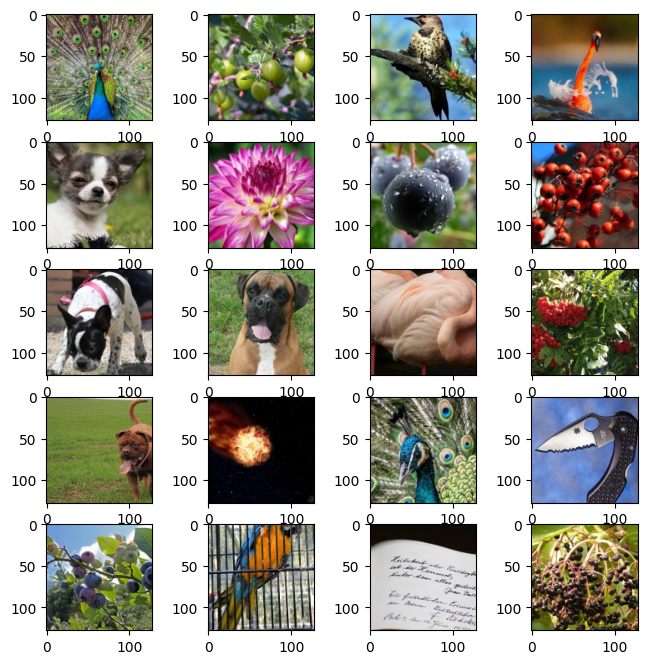

In [15]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [16]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 0.8
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    loss = beta * tf.reduce_sum(tf.square(s_true - s_pred)/(64*64))
    return loss

def psnr_loss(y_true, y_pred):
    n = tf.reduce_max(y_true)  # Max pixel value in y_true
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    psnr = 10 * tf.math.log(10.0) / tf.math.log(10.0) * tf.math.log(n**2 / mse)
    return 1 / psnr

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = beta * psnr_loss(s_true, s_pred)
    c_loss = psnr_loss(c_true, c_pred)
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x3)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x4)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x5)
    x = concatenate([x3, x4, x5])
  
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x3)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x4)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x5)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(reveal_input)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(reveal_input)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(reveal_input)
    
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x3)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x4)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x5)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=psnr_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder
 

In [17]:
def lr_schedule(epoch_idx):
    if epoch_idx < 100:
        return 0.001
    elif epoch_idx < 200:
        return 0.0003
    elif epoch_idx < 300:
        return 0.0001
    else:
        return 0.00003

In [18]:
NB_EPOCHS = 400
BATCH_SIZE = 32
lr = 0.001
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
K.set_value(autoencoder_model.optimizer.lr,lr)
K.set_value(reveal_model.optimizer.lr,lr)
m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        aeloss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3))
        ae_loss.append(aeloss)

        revloss = reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S)
        rev_loss.append(revloss)
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch 1 | Batch:   0 of 1000. Loss AE       0.12 | Loss Rev       0.07:   3%|▎         | 1/32 [00:27<14:05, 27.26s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 1 | Batch:  32 of 1000. Loss AE       0.01 | Loss Rev       0.02:   6%|▋         | 2/32 [00:27<05:44, 11.49s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 1 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:28<03:06,  6.43s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 1 | Batch:  96 of 1000. Loss AE       0.05 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:28<01:53,  4.06s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 1 | Batch: 128 of 1000. Loss AE       0.06 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:28<01:14,  2.75s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 160 of 1000. Loss AE       0.07 | Loss Rev       0.05:  19%|█▉        | 6/32 [00:29<00:50,  1.96s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 1 | Batch: 192 of 1000. Loss AE       0.07 | Loss Rev       0.05:  22%|██▏       | 7/32 [00:29<00:36,  1.46s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 1 | Batch: 224 of 1000. Loss AE       0.07 | Loss Rev       0.05:  25%|██▌       | 8/32 [00:30<00:27,  1.13s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 256 of 1000. Loss AE       0.07 | Loss Rev       0.05:  28%|██▊       | 9/32 [00:30<00:20,  1.10it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 288 of 1000. Loss AE       0.07 | Loss Rev       0.05:  31%|███▏      | 10/32 [00:31<00:16,  1.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 1 | Batch: 320 of 1000. Loss AE       0.08 | Loss Rev       0.05:  34%|███▍      | 11/32 [00:31<00:13,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 352 of 1000. Loss AE       0.08 | Loss Rev       0.05:  38%|███▊      | 12/32 [00:31<00:11,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 384 of 1000. Loss AE       0.08 | Loss Rev       0.05:  41%|████      | 13/32 [00:32<00:10,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 416 of 1000. Loss AE       0.07 | Loss Rev       0.05:  44%|████▍     | 14/32 [00:32<00:09,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 448 of 1000. Loss AE       0.07 | Loss Rev       0.05:  47%|████▋     | 15/32 [00:33<00:08,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 1 | Batch: 480 of 1000. Loss AE       0.07 | Loss Rev       0.05:  50%|█████     | 16/32 [00:33<00:07,  2.16it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 512 of 1000. Loss AE       0.07 | Loss Rev       0.05:  53%|█████▎    | 17/32 [00:34<00:06,  2.21it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 1 | Batch: 544 of 1000. Loss AE       0.07 | Loss Rev       0.05:  56%|█████▋    | 18/32 [00:34<00:06,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 1 | Batch: 576 of 1000. Loss AE       0.07 | Loss Rev       0.05:  59%|█████▉    | 19/32 [00:34<00:05,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 1 | Batch: 608 of 1000. Loss AE       0.07 | Loss Rev       0.05:  62%|██████▎   | 20/32 [00:35<00:05,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 640 of 1000. Loss AE       0.07 | Loss Rev       0.05:  66%|██████▌   | 21/32 [00:35<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 672 of 1000. Loss AE       0.07 | Loss Rev       0.05:  69%|██████▉   | 22/32 [00:36<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 704 of 1000. Loss AE       0.07 | Loss Rev       0.05:  72%|███████▏  | 23/32 [00:36<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 736 of 1000. Loss AE       0.07 | Loss Rev       0.05:  75%|███████▌  | 24/32 [00:37<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 768 of 1000. Loss AE       0.07 | Loss Rev       0.05:  78%|███████▊  | 25/32 [00:37<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 800 of 1000. Loss AE       0.07 | Loss Rev       0.05:  81%|████████▏ | 26/32 [00:37<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 832 of 1000. Loss AE       0.07 | Loss Rev       0.05:  84%|████████▍ | 27/32 [00:38<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 1 | Batch: 864 of 1000. Loss AE       0.07 | Loss Rev       0.05:  88%|████████▊ | 28/32 [00:38<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 1 | Batch: 896 of 1000. Loss AE       0.07 | Loss Rev       0.05:  91%|█████████ | 29/32 [00:39<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1 | Batch: 928 of 1000. Loss AE       0.07 | Loss Rev       0.05:  94%|█████████▍| 30/32 [00:39<00:00,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 1 | Batch: 960 of 1000. Loss AE       0.07 | Loss Rev       0.05:  97%|█████████▋| 31/32 [00:39<00:00,  2.37it/s]

1/1 [==============================] - 1s 787ms/step


Epoch 1 | Batch: 992 of 1000. Loss AE       0.07 | Loss Rev       0.05: 100%|██████████| 32/32 [00:44<00:00,  1.39s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2 | Batch:   0 of 1000. Loss AE       0.06 | Loss Rev       0.04:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 2 | Batch:  32 of 1000. Loss AE       0.06 | Loss Rev       0.04:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 2 | Batch:  64 of 1000. Loss AE       0.05 | Loss Rev       0.04:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch:  96 of 1000. Loss AE       0.05 | Loss Rev       0.04:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2 | Batch: 128 of 1000. Loss AE       0.05 | Loss Rev       0.04:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2 | Batch: 160 of 1000. Loss AE       0.05 | Loss Rev       0.04:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 192 of 1000. Loss AE       0.05 | Loss Rev       0.04:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 224 of 1000. Loss AE       0.05 | Loss Rev       0.04:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 256 of 1000. Loss AE       0.05 | Loss Rev       0.04:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 288 of 1000. Loss AE       0.05 | Loss Rev       0.04:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 2 | Batch: 320 of 1000. Loss AE       0.05 | Loss Rev       0.04:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 2 | Batch: 352 of 1000. Loss AE       0.05 | Loss Rev       0.04:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 2 | Batch: 384 of 1000. Loss AE       0.05 | Loss Rev       0.04:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 416 of 1000. Loss AE       0.05 | Loss Rev       0.04:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 448 of 1000. Loss AE       0.05 | Loss Rev       0.04:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2 | Batch: 480 of 1000. Loss AE       0.05 | Loss Rev       0.03:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2 | Batch: 512 of 1000. Loss AE       0.05 | Loss Rev       0.03:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 544 of 1000. Loss AE       0.05 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 576 of 1000. Loss AE       0.05 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 2 | Batch: 608 of 1000. Loss AE       0.05 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 2 | Batch: 640 of 1000. Loss AE       0.05 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 672 of 1000. Loss AE       0.05 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 704 of 1000. Loss AE       0.05 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2 | Batch: 736 of 1000. Loss AE       0.05 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 2 | Batch: 768 of 1000. Loss AE       0.05 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 2 | Batch: 800 of 1000. Loss AE       0.05 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 832 of 1000. Loss AE       0.05 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch: 864 of 1000. Loss AE       0.05 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 2 | Batch: 896 of 1000. Loss AE       0.05 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 2 | Batch: 928 of 1000. Loss AE       0.05 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2 | Batch: 960 of 1000. Loss AE       0.05 | Loss Rev       0.03:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 992 of 1000. Loss AE       0.05 | Loss Rev       0.03: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 3 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 3 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.03:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.03:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.03:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.03:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 3 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:07<00:05,  2.40it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 3 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 3 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 3 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.03:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.03: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:12,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 4 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 4 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:07,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.03:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.03:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.03:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.03:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 4 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 4 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 4 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.03:  97%|█████████▋| 31/32 [00:13<00:00,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.03: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 5 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 5 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 5 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 5 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 5 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 5 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:07,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.03:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 5 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.03:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.03:  50%|█████     | 16/32 [00:06<00:06,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.03:  53%|█████▎    | 17/32 [00:07<00:06,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 5 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 5 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 5 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 5 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 5 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 5 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 5 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.03:  97%|█████████▋| 31/32 [00:13<00:00,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.03: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:12,  2.41it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.41it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.03:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.03:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.03:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.03:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.03:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.03: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 7 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 7 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.03:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.03:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.03:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.03:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 7 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 7 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 7 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 7 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 7 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 7 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.03:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.03: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 8 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 8 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 8 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.03:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 8 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.03:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 8 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.03:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.03:  53%|█████▎    | 17/32 [00:07<00:06,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 8 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 8 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 8 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 8 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 8 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.03:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.03: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 9 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 9 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.03:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 9 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.03:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 9 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.03:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.03:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 9 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 9 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 9 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 9 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 9 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.03:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.03: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 10 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 10 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 10 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 10 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 10 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 11 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 11 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 11 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 11 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 12 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 12 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 12 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.03:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.03:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.03:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.03:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 13 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 13 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 13 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 13 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 13 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 13 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 14 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 14 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 14 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 14 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 14 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 14 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 14 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.03:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.03:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 14 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.03:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.03:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 14 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 14 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 14 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 14 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 14 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.03:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.03: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:12,  2.41it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 15 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 15 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 15 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 15 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 15 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 15 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 16 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 16 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 16 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 16 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 16 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 16 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 16 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 16 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 16 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 16 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 17 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 17 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 17 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 17 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 17 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 18 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 18 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 18 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 18 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 18 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 18 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 18 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 18 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.03:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.03:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 18 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 18 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.03:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 18 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 18 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 18 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 18 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 18 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.03:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 18 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.03:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.03: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 19 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 19 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 19 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 19 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 19 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.03:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 19 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 19 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.03:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.03:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 19 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 19 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 19 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 19 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 19 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 19 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 19 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 20 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:22,  1.39it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 21 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:01<00:16,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 21 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:14,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 21 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:12,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 21 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 21 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 21 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 21 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 21 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 21 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 21 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 21 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 21 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 22 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 22 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 22 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 22 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 22 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 22 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 22 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 22 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 22 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 22 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 22 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 22 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 22 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 22 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 22 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 22 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 22 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 22 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 22 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 22 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 22 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 22 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 22 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 22 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 22 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 22 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 22 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 22 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 22 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 22 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 22 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 22 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 23 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 23 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 23 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 23 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 23 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 23 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 23 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 23 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 23 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 23 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 23 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.03:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 23 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.03:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 23 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.03:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 23 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.03:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 23 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.03:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 23 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.03:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 23 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.03:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 23 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.03:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 23 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 23 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 24 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 24 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 24 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 24 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 24 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 24 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 24 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 25 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 25 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 25 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 25 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 25 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 25 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 25 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 25 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 25 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 26 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 26 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 26 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 26 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 26 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 26 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 26 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 26 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 26 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 27 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 27 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 27 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 27 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 27 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 27 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 27 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 27 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 27 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 27 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 27 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 27 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 27 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 27 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 27 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 28 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 28 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 28 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 28 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 28 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 28 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 28 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 28 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 28 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 28 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 28 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 28 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 28 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 28 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 28 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 28 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.41it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 29 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 29 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 29 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 29 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 29 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 29 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 29 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 29 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 29 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 29 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 29 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 29 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 29 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 29 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 29 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 29 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 29 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 29 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 30 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 30 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.03:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.03:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 30 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.03:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 30 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.03:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 30 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 30 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 30 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 30 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 30 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 31 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 31 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 31 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 31 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 31 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 31 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 31 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 31 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 31 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 31 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 31 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 31 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 31 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 31 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 31 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 31 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 31 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 31 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 32 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 32 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 32 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 32 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 32 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 32 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 32 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 32 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 32 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 32 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 32 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 32 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 32 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 32 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 32 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 32 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 33 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 33 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 33 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 33 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 33 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 34 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 34 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 34 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 34 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 34 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 34 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 34 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 34 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 34 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 34 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 34 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 34 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 34 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 34 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 35 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 35 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 35 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 35 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 35 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 35 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 36 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 36 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 36 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 36 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 36 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 36 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 36 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 36 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.40it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 37 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 37 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 37 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 37 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 37 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 37 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 37 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 37 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 38 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 38 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 38 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 38 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.03:  25%|██▌       | 8/32 [00:03<00:10,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 38 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 38 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 38 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 38 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 38 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 38 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 38 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 38 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 38 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 38 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 38 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 38 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 38 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 38 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 39 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 39 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 39 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 39 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 39 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 39 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 39 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 39 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 39 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 39 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 39 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 39 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 39 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 39 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 39 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 39 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 40 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 40 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 40 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 40 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 40 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 40 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 40 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 40 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 40 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 40 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 40 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 40 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 40 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 41 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 41 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 41 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 41 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 41 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 41 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 41 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 41 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 41 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 42 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 42 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 42 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 42 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 42 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 42 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 42 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 42 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 42 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 43 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 43 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 43 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 43 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 43 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 43 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 43 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 43 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 43 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 43 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 43 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 43 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 43 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 43 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 43 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 43 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 44 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 44 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 44 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 44 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 44 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 44 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 45 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 45 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 45 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 45 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 45 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 45 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 45 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 46 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 46 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 46 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 46 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 46 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 46 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 46 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 47 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 47 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 47 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 47 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 47 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 47 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 47 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 47 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 47 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 47 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 47 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 47 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 47 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 47 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 47 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 48 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 48 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 48 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 48 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 48 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 48 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 49 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 49 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 49 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 50 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 50 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 50 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 50 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 50 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 50 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 50 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 51 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 51 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 51 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 52 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 52 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 52 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 52 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 52 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 52 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 53 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 53 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 53 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 53 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:13,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 53 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:04<00:10,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:05<00:09,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 53 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 53 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 53 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 53 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:08<00:06,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 53 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:11<00:03,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 53 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 53 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 53 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 53 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 53 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 53 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 53 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 54 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 54 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 54 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 54 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 54 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 54 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 54 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 54 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 55 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 55 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 55 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 55 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 55 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 55 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 55 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 55 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 55 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 55 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 55 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 55 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 55 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 55 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 55 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 55 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 55 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 55 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 55 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 55 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 55 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 55 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 55 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 55 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 55 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 55 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 55 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 55 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 55 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 55 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 55 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 55 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 56 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 56 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 56 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 56 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 56 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 56 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 56 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 56 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 56 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 56 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 56 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 56 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 56 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 56 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 56 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 57 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 57 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 57 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 57 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 58 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 58 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 58 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 58 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 58 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 58 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 58 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 58 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 58 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 58 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 58 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 58 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 58 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 58 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 59 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 59 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 59 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 59 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 59 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 59 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 59 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 59 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 59 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 59 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 59 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 59 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 59 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 59 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 59 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 59 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 60 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 60 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 60 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 60 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 60 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 60 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 60 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 60 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 60 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 60 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 60 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 61 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 61 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 61 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 61 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 61 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 61 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 61 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 62 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 62 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 62 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 62 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 62 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 62 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 62 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 62 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 63 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 63 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 63 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 63 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 63 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 63 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 63 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 64 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 64 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 64 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 64 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 64 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 64 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 65 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 65 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 65 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 65 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 65 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 65 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 66 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 66 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 66 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 66 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 66 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 67 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 67 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 67 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 67 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 68 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 68 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 68 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 68 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 68 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 68 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.03:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.03:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.03:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.03:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.03:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.03:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.03:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 69 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 69 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 69 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 69 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 69 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 70 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 70 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 70 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 70 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 70 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 70 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 71 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 71 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 71 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 72 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 72 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 72 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 72 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 72 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 73 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 73 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 73 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 73 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 73 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 73 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 73 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 73 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 73 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 73 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 73 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 74 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 74 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 74 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 75 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 75 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 75 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 75 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 75 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 76 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 76 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 76 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 76 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 76 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 76 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 76 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 76 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 76 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 76 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 76 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 77 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 77 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 77 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 77 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 77 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 77 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 78 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 78 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 78 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 78 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 79 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 79 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 79 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 80 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 81 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 81 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 81 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 81 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 81 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 81 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 81 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 81 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 82 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 82 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 82 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 83 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 83 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 83 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 84 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 84 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 84 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 84 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 84 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 85 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 85 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 85 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 85 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 85 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 85 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:14,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:12,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 85 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:11,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 85 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:04<00:10,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 85 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:10,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 85 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:05<00:09,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 85 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 85 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 85 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 85 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:07<00:06,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 85 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 85 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:08<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 85 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 85 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 85 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 85 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 85 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:11<00:03,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 85 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 85 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 85 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 86 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 86 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 86 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 86 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 86 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 86 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 86 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 86 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 86 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 86 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 87 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 87 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 87 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 87 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 87 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 87 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 87 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 87 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 87 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 87 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 87 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 87 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 87 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 87 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 87 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 87 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 87 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 87 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 87 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 87 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 87 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 87 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 87 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 88 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 88 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 88 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 88 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 88 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 88 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 88 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 89 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 89 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 89 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 89 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 89 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 89 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 89 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 89 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 90 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 90 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 90 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 90 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 90 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 90 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 90 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 90 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 90 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 90 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 90 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 90 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 91 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 91 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 91 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 91 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 91 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 91 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 91 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 91 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 91 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 91 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 91 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 92 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 92 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 93 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 93 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 93 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 93 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 93 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 94 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 94 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 94 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 94 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 94 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 94 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 94 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 94 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 94 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 95 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 95 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 95 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 95 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 95 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 95 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 96 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 96 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 96 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 97 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 97 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 97 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 97 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 97 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 97 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 97 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 98 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 98 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 98 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 98 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 98 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 98 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 100 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 100 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 100 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 100 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 100 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 100 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 100 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 100 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 100 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 100 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 100 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 100 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 101 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 101 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 101 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 101 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 101 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 101 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 101 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 101 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 101 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 101 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 101 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 101 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 101 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 101 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 101 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 101 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 101 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 101 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 101 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 101 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 102 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 102 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 102 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 102 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 102 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 102 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 102 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 102 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 102 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 102 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 102 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 102 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 103 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 103 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 103 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 103 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 103 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 103 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 103 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 103 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 103 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 103 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 103 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 103 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 103 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 104 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 104 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 104 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 104 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 104 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 104 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 105 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 105 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 105 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 105 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 105 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 105 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 105 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 105 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 105 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 105 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 105 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 105 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 105 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 105 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 105 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 106 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 106 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 106 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 106 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 106 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 106 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 106 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 106 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 106 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 106 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 106 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 106 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 106 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 107 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 107 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 107 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 107 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 107 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 107 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 107 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 107 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 107 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 107 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 108 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 108 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 108 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 108 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 108 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 108 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 108 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 108 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 108 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 108 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 108 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 108 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 108 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 109 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 109 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 109 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 109 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 109 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 109 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 109 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 109 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 109 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 109 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 109 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 109 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 109 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 109 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 109 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 109 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 110 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 110 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 110 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 110 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 110 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 110 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 110 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 110 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 111 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 111 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 111 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 111 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 111 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 111 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 111 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 111 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 111 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 111 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 111 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 111 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 112 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 112 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 112 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 112 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 112 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 112 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 112 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 112 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 112 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 112 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 112 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 112 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 112 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 112 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 112 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 112 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 113 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 113 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 113 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 113 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 113 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 113 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 113 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 113 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 113 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 113 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 113 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 113 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 113 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 113 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 113 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 113 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 114 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 114 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 114 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:10,  2.24it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.28it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 114 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 114 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 114 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 114 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 114 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 114 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 114 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 114 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 114 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 114 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 114 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 114 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 115 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 115 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 115 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 115 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 115 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 115 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 115 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 115 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 115 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 115 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 115 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 116 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 116 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 116 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 116 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 116 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 116 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 116 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 116 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 116 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 116 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 116 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 116 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 117 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 117 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 117 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 117 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 117 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 117 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 117 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 117 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 117 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 117 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 117 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 117 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 117 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 117 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:06,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 117 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 117 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:05,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:04,  2.21it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:11<00:03,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 117 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 117 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 117 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 117 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 117 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 118 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 118 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 118 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 118 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 118 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 118 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 118 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 118 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 118 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 118 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 118 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 118 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 118 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 118 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 118 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 118 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 118 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 118 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 118 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 119 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 119 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 119 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 119 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 119 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 119 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 119 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 119 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 119 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 119 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 119 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 119 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 119 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 119 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 119 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 119 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 119 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 119 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 119 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 119 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 119 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 119 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 119 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 119 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 119 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 120 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 120 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 120 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 120 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 120 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 120 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 120 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 120 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 120 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 120 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 120 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 120 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 120 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 120 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 120 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 120 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 120 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 120 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 120 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 120 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 120 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 120 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 120 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 120 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 121 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 121 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 121 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 121 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 121 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 121 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 121 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 121 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 121 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 121 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 121 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 122 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 122 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 122 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 122 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 122 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 122 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 122 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 122 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 122 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 122 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 122 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 122 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 122 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 123 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 123 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 123 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 123 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 123 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 123 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 123 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 123 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 124 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 124 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 124 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 124 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 124 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 124 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 124 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 124 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 124 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 124 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 124 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 124 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 124 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 124 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 124 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 125 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 125 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 125 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 125 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 125 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 125 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 125 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 125 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 125 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 125 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 125 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 125 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 125 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 125 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 126 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 126 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 126 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 126 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 126 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 126 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 126 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 126 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 126 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 126 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 126 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 126 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 126 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 126 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 126 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 126 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 126 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 126 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 126 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 126 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 126 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 127 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 127 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 127 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 127 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 127 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 127 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 127 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 127 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 127 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 127 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 127 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 127 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 127 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 128 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 128 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 128 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 128 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 128 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 128 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 128 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 128 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 128 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 128 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 128 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 128 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 128 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 128 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 128 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 128 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 128 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 128 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 128 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 128 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 128 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 128 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 129 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 129 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 129 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 129 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 129 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 129 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 129 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 129 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 129 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 129 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 129 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 129 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 129 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 129 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 129 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 129 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 129 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 129 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 129 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 130 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 130 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 130 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 130 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 130 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 130 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 130 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 130 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 130 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 130 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 130 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 130 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 130 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 130 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 130 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 130 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 130 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 130 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 130 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 130 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 130 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 130 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 131 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 131 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 131 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 131 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 131 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 131 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 131 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 131 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 131 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 131 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 131 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 131 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 131 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 131 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 132 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 132 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 132 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 132 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 132 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 132 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 132 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 132 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 132 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 132 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 132 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 133 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 133 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 133 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 133 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 133 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 133 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 133 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 133 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 133 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 133 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 133 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 133 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 134 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 134 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 134 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 134 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 134 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 134 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 134 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 134 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 134 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 134 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 134 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 134 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 134 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 135 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 135 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 135 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 135 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 135 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 135 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 135 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 135 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 135 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 135 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 135 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 135 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 135 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 135 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 135 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 136 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 136 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 136 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 136 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 136 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 136 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 136 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 136 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 136 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 136 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 136 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 136 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 136 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 136 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 136 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 136 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 136 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 136 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 136 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 136 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 136 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 136 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 136 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 136 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 137 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 137 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 137 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 137 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 137 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 137 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 137 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 137 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 137 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 137 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 137 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 137 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 137 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 137 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 137 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 137 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 137 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 138 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 138 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 138 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 138 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 138 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 138 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 138 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 138 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 138 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 138 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 138 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 138 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 139 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 139 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 139 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 139 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 139 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 139 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 139 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 139 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 139 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 139 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 139 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 139 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 139 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 139 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 139 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 140 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 140 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 140 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 140 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 140 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 140 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 140 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 140 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 140 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 140 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 140 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 140 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 140 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 140 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 141 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 141 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 141 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 141 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 141 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 141 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 141 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 141 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 141 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 141 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 141 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 141 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 141 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 141 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 142 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 142 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 142 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 142 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 142 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 142 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 142 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 142 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 142 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 142 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 142 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 142 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 142 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 142 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 143 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 143 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 143 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 143 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 143 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 143 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 143 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 143 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 143 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 143 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 143 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 143 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 143 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 143 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 143 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 143 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 143 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 143 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 143 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 143 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 143 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 143 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 143 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 143 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 143 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 144 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 144 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 144 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 144 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 144 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 144 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 144 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 144 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 144 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 144 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 144 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 144 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 144 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 144 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 144 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 145 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 145 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 145 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 145 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 145 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 145 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 145 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 145 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 145 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 145 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 145 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 146 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 146 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 146 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 146 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 146 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 146 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 146 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 146 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 146 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 146 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 146 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 146 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 146 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 146 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 146 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 146 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 146 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 146 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 146 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 146 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 146 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 146 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 146 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 146 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 147 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 147 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 147 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 147 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 147 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 147 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 147 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 147 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 147 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 147 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 147 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 147 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 147 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 147 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 147 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 147 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 147 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 147 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 148 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 148 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 148 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 148 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 148 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 148 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 148 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 148 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 148 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 148 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 148 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 148 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 148 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 148 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 148 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 148 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 148 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 149 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 149 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 149 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 149 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 149 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 149 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 149 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 149 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 149 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 149 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 149 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 149 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 149 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 149 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 149 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 149 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:07<00:08,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 149 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:07,  1.97it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 149 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:08<00:06,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 149 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:06,  2.13it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 149 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 149 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:05,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 149 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.23it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 149 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 149 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 149 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:11<00:03,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 149 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 149 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:12<00:02,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 149 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 149 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 149 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 149 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 149 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 150 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 150 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 150 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 150 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 150 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 150 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 150 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 150 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 150 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 150 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 150 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 150 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 150 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 150 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 150 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 150 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 150 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 150 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 150 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 150 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 150 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 150 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 150 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 150 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 150 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 150 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 150 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 150 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 150 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 150 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 150 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 150 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 151 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 151 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 151 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 151 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 151 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 151 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 151 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 151 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 151 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 151 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 151 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 151 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 151 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 151 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 151 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 151 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 151 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 151 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 151 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 151 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 151 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 151 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 151 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 151 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 151 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 151 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 151 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 151 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 151 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 151 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 151 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 151 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 152 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 152 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 152 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 152 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 152 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 152 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 152 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 152 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 152 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 152 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 152 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 152 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 152 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 152 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 152 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 152 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 152 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 152 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 152 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 152 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 152 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 152 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 152 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 153 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 153 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 153 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 153 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 153 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 153 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 153 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 153 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 153 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 153 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 153 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 153 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 154 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.26it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 154 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 154 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 154 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 154 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 154 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 154 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 154 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 154 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 154 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 154 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 154 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 154 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 154 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 154 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 154 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 154 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 154 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 154 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 154 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 155 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 155 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 155 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 155 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 155 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 155 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 155 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 155 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 155 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 155 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 155 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 155 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 155 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 155 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 156 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.25it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 156 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 156 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 156 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 156 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 156 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 156 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 156 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 156 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 156 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 156 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 156 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 156 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 156 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 156 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 156 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 156 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 156 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 156 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 156 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 156 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 156 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 156 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 156 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 156 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 157 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 157 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 157 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 157 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 157 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 157 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 157 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 157 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 157 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 157 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 157 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 157 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 157 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 157 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 158 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 158 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 158 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 158 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 158 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 158 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 158 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 158 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 158 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 158 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 158 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 158 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 158 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 158 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 158 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 159 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 159 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 159 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 159 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 159 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 159 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 159 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 159 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 159 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 159 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 159 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 159 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 159 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 159 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 159 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 159 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 159 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 159 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 159 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 159 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 159 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 159 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 159 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 160 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 160 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 160 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 160 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 160 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 160 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 160 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 160 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 160 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 161 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 161 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 161 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 161 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 161 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 161 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 162 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 162 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 162 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 162 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 162 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 162 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 162 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 162 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 162 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 162 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 162 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 162 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 162 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 162 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 162 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 163 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 163 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 163 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 163 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 163 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 163 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 163 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 163 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 163 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 163 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 163 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 163 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 163 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 163 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 163 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 164 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 164 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 164 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 164 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 164 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 164 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 164 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 164 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 164 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 164 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 164 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 164 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 164 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 164 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 164 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 164 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 164 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 164 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 165 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 165 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 165 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 165 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 165 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 165 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 165 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 165 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 165 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 165 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 165 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 166 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 166 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 166 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 166 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 166 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 166 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 166 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 166 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 166 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 166 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 166 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 166 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 166 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 166 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 166 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 166 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 166 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 166 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 166 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 166 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 167 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 167 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 167 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 167 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 167 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 167 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 167 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 167 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 167 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 167 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 167 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 167 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 168 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 168 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 168 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 168 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 168 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 168 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 168 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 168 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 168 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 168 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 168 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 169 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 169 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 169 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 169 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 169 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 169 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 169 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 169 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 169 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 170 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 170 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 170 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 170 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 170 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 170 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 170 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 170 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 170 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 170 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 170 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 170 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 171 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 171 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 171 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 171 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 171 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 171 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 171 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 171 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 171 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 171 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 171 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 171 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 171 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 171 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 171 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 171 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 171 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 171 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 171 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 171 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 172 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 172 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 172 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 172 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 172 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 172 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 172 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 172 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 172 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 172 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 172 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 172 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 172 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 172 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 172 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 172 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 173 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 173 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 173 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 173 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 173 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 173 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 173 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 173 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 173 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 173 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 173 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 173 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 173 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 173 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 173 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 173 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 173 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 173 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 173 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 173 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 173 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 173 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 173 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 173 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 173 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 173 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 174 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 174 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 174 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 174 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 174 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 174 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 174 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 174 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 174 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 174 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 174 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 174 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 174 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 174 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 174 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 174 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 175 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 175 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 175 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 175 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 175 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 175 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 175 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 175 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 175 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 175 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 175 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 176 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 176 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 176 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 176 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 176 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 176 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 176 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 176 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 176 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 176 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 176 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 176 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 176 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 176 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 176 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 176 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 176 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 176 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 177 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 177 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 177 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 177 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 177 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 177 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 177 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 177 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 177 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 177 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 177 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 177 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 177 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 178 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 178 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 178 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 178 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 178 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 178 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 178 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 178 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 178 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 178 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 178 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 178 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 179 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 179 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 179 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 179 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 179 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 179 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 179 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 179 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 179 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 179 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 179 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 179 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 179 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 179 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 179 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 179 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 180 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 180 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 180 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 180 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 180 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 180 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 180 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 180 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 180 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 180 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 180 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 180 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 181 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 181 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 181 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 181 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 181 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 181 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 181 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 181 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 181 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 181 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 181 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 181 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 181 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:06,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 181 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:06,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 181 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:05,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 181 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 181 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:04,  2.20it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 181 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 181 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:11<00:03,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 181 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 181 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 181 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 181 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 181 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 181 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 181 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 182 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 182 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 182 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 182 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 182 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 182 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 182 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 182 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 182 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 182 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 182 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 182 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 182 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 182 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 182 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 182 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 182 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 182 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 182 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 182 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 182 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 183 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 183 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 183 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 183 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 183 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 183 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.26it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 183 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:11,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 183 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 183 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 183 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 183 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 183 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 183 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 183 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 183 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 183 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 183 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 183 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 183 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 183 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 183 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 183 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 183 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 183 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 183 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 183 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 183 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 183 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 183 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 183 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 183 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 183 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 184 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 184 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 184 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 184 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 184 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 184 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 184 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 184 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 184 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 184 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 184 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 184 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 184 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 184 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 184 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 184 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 184 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 184 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 184 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 184 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 184 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 184 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 184 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 184 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 184 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 185 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 185 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 185 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 185 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 185 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 185 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 185 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 185 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 185 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 185 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 185 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 185 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 185 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 185 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 185 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 185 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 185 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 185 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 185 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 186 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 186 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 186 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 186 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 186 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 186 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 186 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 186 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 186 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 186 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 186 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 186 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 186 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 186 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 187 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 187 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 187 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 187 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 187 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 187 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 187 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 187 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 187 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 187 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 187 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 187 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 187 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 187 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 187 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 187 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 188 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 188 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 188 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 188 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 188 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 188 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 188 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 188 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 188 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 188 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 188 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 188 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 188 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 188 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 188 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 188 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 188 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 188 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 188 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 188 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 188 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 188 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 188 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 189 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 189 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 189 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 189 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 189 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 189 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 189 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 189 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 189 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 189 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 190 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 190 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 190 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 190 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 190 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 190 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 190 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 190 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 190 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 190 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 190 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 190 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 190 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 190 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 190 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 190 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 190 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 191 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 191 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 191 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 191 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 191 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 191 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 191 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 191 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 191 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 191 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 191 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 191 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 191 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 191 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 191 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 191 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 191 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 191 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 191 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 191 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 191 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 191 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 192 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 192 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 192 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 192 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 192 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 192 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 192 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 192 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 192 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 192 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 192 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 192 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 193 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 193 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 193 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 193 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 193 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 193 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 193 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 193 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 193 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 193 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 193 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 193 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 193 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 193 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 194 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 194 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 194 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 194 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 194 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 194 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 194 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 194 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 194 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 194 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 194 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 194 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 194 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 194 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 194 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 195 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 195 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 195 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 195 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 195 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 195 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 195 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 195 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 195 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 196 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 196 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 196 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 196 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 196 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 196 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 196 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 196 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 196 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 196 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 197 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 197 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 197 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 197 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 197 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 197 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 197 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 197 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 197 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 197 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 197 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 197 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 197 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 197 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 197 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 197 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 197 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 197 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 197 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 197 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 197 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 197 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 197 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 197 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 198 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 198 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 198 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 198 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 198 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 198 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 198 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 198 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 198 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 198 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 198 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 198 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 198 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 198 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 198 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 198 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 198 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 198 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 198 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 198 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 198 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 198 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 198 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 198 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 199 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 199 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 199 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 199 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 199 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 199 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 199 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 199 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 199 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 199 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 199 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 199 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 199 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 199 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 199 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 199 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 199 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 199 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 199 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 199 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 200 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 200 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 200 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 200 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 200 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 200 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 200 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 200 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 200 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 200 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 200 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 201 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 201 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 201 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 201 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 201 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 201 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 201 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 201 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 201 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 201 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 201 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 201 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 201 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 201 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 202 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 202 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 202 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 202 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 202 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 202 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 202 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 202 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 202 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 202 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 202 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 203 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 203 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 203 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 203 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 203 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 203 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 203 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 203 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 203 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 203 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 203 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 203 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 203 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 203 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 203 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 203 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 203 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 203 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 203 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 204 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 204 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:12,  2.13it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 204 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:11,  2.25it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 204 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 204 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 204 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 204 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 204 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 204 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 204 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 204 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 204 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 204 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 204 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 205 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 205 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 205 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 205 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 205 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 205 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 205 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 205 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 205 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 205 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 205 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 205 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 206 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 206 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 206 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 206 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 206 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 206 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 206 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 206 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 206 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 206 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 206 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 206 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 206 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 206 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 207 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 207 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 207 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 207 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 207 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 207 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 207 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 207 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 207 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 207 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 207 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 207 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 207 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 207 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 207 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 207 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 207 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 207 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 208 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 208 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 208 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 208 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 208 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 208 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 208 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 208 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 208 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 208 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 208 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 208 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 208 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 208 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 208 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 208 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 208 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 208 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 208 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 209 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 209 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 209 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 209 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 209 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 209 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 209 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 209 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 209 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 209 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 209 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 209 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 209 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 209 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 210 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 210 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 210 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 210 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 210 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 210 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 210 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 210 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 210 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 210 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 210 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 210 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 210 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 210 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 210 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 211 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 211 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 211 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 211 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 211 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 211 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 211 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 211 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 211 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 211 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 211 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 211 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 211 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 211 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 212 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 212 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 212 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 212 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 212 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 212 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 212 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 212 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 212 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 212 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 212 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 212 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 212 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 213 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 213 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 213 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 213 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 213 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 213 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 213 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 213 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 213 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 213 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 213 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:05<00:11,  1.85it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 213 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:10,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 213 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:09,  2.06it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 213 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:08,  2.12it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 213 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 213 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:07<00:07,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 213 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.23it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 213 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:08<00:06,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 213 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 213 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:09<00:05,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 213 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 213 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 213 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 213 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 213 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:11<00:03,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 213 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 213 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:12<00:02,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 213 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 213 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 213 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 213 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 213 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 214 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 214 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 214 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 214 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:10,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 214 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 214 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 214 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 214 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 214 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 214 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 214 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 214 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 214 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 214 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 214 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 214 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 214 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 214 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 214 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 214 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 215 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 215 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 215 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 215 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 215 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 215 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 215 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 215 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 215 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 215 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 215 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 215 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 215 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 215 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 215 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 215 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 215 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 215 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 215 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 215 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 215 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 215 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 215 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 215 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 215 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 216 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 216 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 216 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 216 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 216 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 216 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 216 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 216 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 216 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 216 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 216 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 216 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 216 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 216 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 217 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 217 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 217 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 217 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 217 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 217 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 217 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 217 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 217 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 217 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 217 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 218 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 218 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 218 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 218 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 218 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 218 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 218 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 218 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 218 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 218 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 218 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 218 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 218 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 219 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 219 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 219 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 219 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 219 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 219 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 219 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 219 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 219 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 219 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 219 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 220 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.27it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 220 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 220 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 220 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 220 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 220 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 220 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 220 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 220 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 220 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 220 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 220 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 220 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 220 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 220 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 220 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 220 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 220 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 220 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 220 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 220 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 220 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 220 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 220 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 221 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 221 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 221 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 221 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 221 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 221 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 221 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 221 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 221 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 221 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 221 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 221 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 221 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 221 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 221 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 221 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 221 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 221 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 221 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 221 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 222 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 222 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 222 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 222 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 222 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 222 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 222 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 222 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 222 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 222 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 222 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 222 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 222 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 222 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 222 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 222 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 222 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 222 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 223 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 223 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 223 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 223 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 223 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 223 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 223 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 223 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.27it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 224 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 224 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 224 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 224 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 224 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 224 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 224 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 224 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 224 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 224 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 224 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 224 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 224 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 224 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 224 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 224 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 224 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 224 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 224 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 224 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 225 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 225 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 225 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 225 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 225 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 225 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 225 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 225 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 225 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 225 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 225 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 225 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 225 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 225 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 226 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 226 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 226 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 226 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 226 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 226 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 226 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 226 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 226 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 226 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 226 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 227 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 227 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 227 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 227 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 227 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 227 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 227 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 227 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 227 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 227 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 227 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 227 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 227 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 228 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 228 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 228 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 228 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 228 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 228 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 228 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 228 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 228 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 228 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 228 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 228 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 228 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 228 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 228 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 228 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 228 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 228 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 228 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 229 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 229 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 229 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 229 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 229 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 229 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 229 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 229 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 229 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 229 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 229 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 229 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 229 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 229 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 229 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 229 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 229 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 230 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 230 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 230 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 230 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 230 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 230 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 230 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 230 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 230 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 230 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 230 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 230 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 230 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 230 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 230 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 230 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 231 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 231 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 231 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 231 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 231 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 231 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 231 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 231 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 231 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 231 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 231 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 231 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 231 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 231 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 231 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 231 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 232 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 232 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 232 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 232 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 232 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 232 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 232 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 232 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 232 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 232 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 232 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 232 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 233 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 233 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 233 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 233 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 233 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 233 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 233 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 233 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 233 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 233 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 234 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 234 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 234 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 234 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 234 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 234 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 234 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 234 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 234 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 234 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 234 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 235 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 235 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 235 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 235 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 235 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 235 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 235 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 235 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 235 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 235 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 235 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 235 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 235 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 235 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 235 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 235 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 235 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 235 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 235 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 235 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 235 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 235 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 235 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 235 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 236 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 236 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 236 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 236 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 236 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 236 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 236 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 236 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 236 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 236 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 236 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 236 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 236 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 236 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 237 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 237 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 237 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 237 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 237 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 237 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 237 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 237 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 237 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 237 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 237 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 237 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 237 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 238 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 238 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 238 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 238 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 238 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 238 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 238 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 238 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 238 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 238 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 238 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 238 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 238 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 238 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 238 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 238 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 238 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 238 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 238 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 238 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 239 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 239 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 239 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 239 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 239 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 239 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 239 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 239 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 239 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 239 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 239 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 239 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 239 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 239 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 239 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 239 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 239 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 239 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 239 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 239 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 239 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 240 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 240 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 240 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 240 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 240 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 240 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 240 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 240 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 240 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 240 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 240 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 240 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 240 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 240 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 240 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 241 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 241 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 241 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 241 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 241 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 241 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 241 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 241 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 241 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 241 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 241 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 241 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 241 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 241 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 241 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 241 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 242 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 242 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 242 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 242 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 242 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 242 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 242 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 242 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 242 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 242 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 242 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 242 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 242 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 242 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 243 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 243 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 243 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 243 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 243 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 243 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 243 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 243 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 243 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 243 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 243 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 243 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 243 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 243 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 243 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 243 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 243 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 243 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 243 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 243 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 243 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 243 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 244 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 244 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 244 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 244 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 244 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 244 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 244 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 244 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 245 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 245 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 245 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 245 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:02<00:15,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 245 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:13,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 245 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:12,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 245 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:11,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 245 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:11,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 245 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:04<00:10,  2.21it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 245 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 245 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:05<00:09,  2.25it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 245 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 245 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 245 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 245 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 245 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:07<00:06,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 245 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 245 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:08<00:06,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 245 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 245 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:09<00:05,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 245 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 245 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 245 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 245 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 245 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:11<00:03,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 245 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 245 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:12<00:02,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 245 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 245 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 245 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 245 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 245 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 246 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 246 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 246 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 246 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 246 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 246 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 246 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 246 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 246 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 246 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 246 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 246 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 246 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 246 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 246 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 246 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 246 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 246 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 246 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 246 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 246 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 246 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 246 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 246 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 247 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 247 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 247 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 247 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 247 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 247 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 247 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 247 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 247 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 247 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 247 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 247 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 247 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 247 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 247 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 247 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 247 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 247 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 247 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 247 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 247 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 247 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 247 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 247 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 247 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 247 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 248 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 248 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 248 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 248 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 248 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 248 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 248 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 248 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 248 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 248 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 248 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 248 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 248 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 248 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 248 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 248 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 248 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 248 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 248 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 248 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 249 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 249 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 249 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 249 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 249 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 249 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 249 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 249 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 249 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 249 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 249 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 249 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 249 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 249 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 250 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 250 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 250 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 250 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 250 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 250 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 250 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 250 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 250 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 250 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 250 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 250 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 250 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 251 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 251 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 251 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 251 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 251 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 251 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 251 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 251 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 251 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 251 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 251 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 251 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 251 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 251 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 251 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 251 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 252 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 252 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 252 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 252 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 252 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 252 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 252 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 252 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 252 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 252 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 252 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 252 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 253 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 253 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 253 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 253 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 253 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 253 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 253 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 253 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 253 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 253 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 253 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 253 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 253 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 253 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 253 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 253 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 253 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 253 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 253 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 253 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 253 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 253 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 254 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 254 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 254 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 254 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 254 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 254 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 254 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 254 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 254 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 254 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 255 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 255 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 255 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 255 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 255 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 255 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 255 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:07,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 255 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 255 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 255 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 255 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 255 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 255 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 255 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 255 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 256 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 256 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 256 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 256 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 256 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 256 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 256 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 256 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 256 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 256 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 256 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 256 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 256 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 257 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 257 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 257 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 257 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 257 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 257 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 257 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 257 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 257 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 257 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 257 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 258 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 258 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 258 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 258 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 258 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 258 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 258 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 258 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 258 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 258 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 258 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 258 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 258 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 259 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 259 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 259 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 259 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 259 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 260 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 260 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 260 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 260 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 260 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 260 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 260 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 260 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 260 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 260 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 260 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 260 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 260 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 260 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 260 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 260 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 261 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 261 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 261 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 261 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 261 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 261 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 261 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 261 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 261 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 261 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 262 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 262 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 262 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 262 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 262 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 262 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 262 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 262 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 262 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 262 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 262 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 263 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 263 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 263 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 263 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 263 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 263 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 263 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 263 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 263 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 263 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 263 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 263 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 263 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 263 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 264 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 264 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 264 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 264 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 264 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 264 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 264 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 264 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 264 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 264 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 264 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 264 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 264 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 264 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 264 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 264 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 264 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 264 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 264 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 264 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 265 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 265 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 265 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 265 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 265 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 265 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.24it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 266 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 266 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 266 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 266 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 266 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 266 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 266 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 266 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 267 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 267 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 267 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 267 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 267 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 267 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 267 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 267 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 267 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 267 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 267 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 267 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 267 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 267 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 267 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 267 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 267 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 267 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 268 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 268 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 268 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 268 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 268 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 268 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 268 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 268 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 268 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 268 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 268 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 269 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 269 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 269 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 269 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 269 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 269 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 269 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 269 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 270 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 270 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 270 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 270 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 270 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 270 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 270 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 270 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 270 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 270 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 270 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 270 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 270 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 270 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 270 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 270 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 270 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 270 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 270 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 270 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 270 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 271 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 271 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 271 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 271 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 271 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 271 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 271 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 271 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 271 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 271 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 271 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 271 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 272 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 272 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 272 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 272 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 272 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 272 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 272 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 272 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 272 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 272 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 272 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 272 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 272 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 272 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 272 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 272 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 273 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 273 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 273 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 273 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 273 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 273 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 273 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 273 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 273 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 274 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 274 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 274 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 274 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 274 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 274 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 274 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 274 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 274 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 274 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 274 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 274 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 274 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 274 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 275 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 275 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 275 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 275 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 275 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 275 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 275 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 275 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 275 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 275 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 275 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 275 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 275 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 275 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 275 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 276 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 276 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 276 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 276 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 276 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 276 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 276 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 276 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 276 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 276 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 276 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 276 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 276 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 276 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 277 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 277 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 277 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 277 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 277 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:14,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 277 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:13,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 277 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:12,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 277 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:11,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 277 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:04<00:10,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 277 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.24it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 277 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:05<00:09,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 277 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 277 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 277 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 277 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 277 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 277 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 277 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:08<00:06,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 277 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 277 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 277 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 277 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 277 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:10<00:03,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 277 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 277 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:11<00:03,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 277 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 277 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:12<00:02,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 277 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 277 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 277 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 277 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.27it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 277 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 278 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 278 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 278 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 278 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 278 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 278 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 278 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 278 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 278 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 278 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 278 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 278 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 278 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 278 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 278 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 278 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:07,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 278 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 278 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 278 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 278 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 278 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 278 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 278 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 278 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 278 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 278 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 278 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 278 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 278 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 278 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:13<00:00,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 278 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 278 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 279 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 279 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 279 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 279 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 279 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 279 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 279 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 279 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 279 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:07,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 279 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 279 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:06,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 279 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 279 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:09<00:04,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 279 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 279 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 279 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 279 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 279 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 279 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 279 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 279 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 279 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 279 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 280 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 280 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 280 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 280 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 280 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 280 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 280 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 280 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 280 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 280 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 281 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 281 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 281 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 281 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 281 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 281 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 281 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 281 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 281 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 281 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 281 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 281 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 281 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 281 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 281 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 281 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 281 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 281 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 281 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 281 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 281 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 281 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 281 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 282 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 282 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 282 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 282 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 282 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 282 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 282 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 282 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 282 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 282 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 282 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 282 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 282 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 282 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 282 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 282 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 282 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 283 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 283 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 283 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 283 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 283 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 283 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 283 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 283 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 283 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 283 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 283 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 283 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 283 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 283 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 283 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 283 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 283 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 283 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 283 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 283 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 283 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 283 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 283 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 284 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 284 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 284 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 284 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 284 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 284 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 284 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 284 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 284 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:07,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 284 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 284 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 284 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 284 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 284 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 284 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 284 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 284 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 284 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 284 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 285 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 285 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 285 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 285 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 285 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 285 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 285 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 285 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 285 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 285 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 285 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 285 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 285 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 285 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 285 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 285 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 286 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 286 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 286 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 286 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 286 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 286 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 286 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 286 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 286 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 286 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 286 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 286 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 286 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 286 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 286 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 287 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 287 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 287 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 287 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 287 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 287 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 287 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 287 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 287 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 287 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 287 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 287 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 287 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 288 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 288 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 288 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 288 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 288 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.02:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.02:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 288 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.02:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 288 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.02:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.02:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 288 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.02:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.02:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.02:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 288 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.02:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.02:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.02:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 288 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.02:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.02:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.02:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 288 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.02:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.02:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 288 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.02:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.02:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 288 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.02:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.02:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 288 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.02:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 288 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.02: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 289 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 289 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 289 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 289 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 289 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 289 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 289 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 289 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 289 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 289 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 289 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 289 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 289 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 289 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 289 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 289 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 289 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 289 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 290 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 290 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 290 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 290 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 290 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 290 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 290 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 290 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 290 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 290 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 290 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 290 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 290 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 290 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 290 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 290 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 290 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 290 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 290 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 290 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 290 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 291 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 291 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 291 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 291 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 291 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 291 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 291 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 291 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 291 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 291 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 291 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 291 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 292 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 292 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 292 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 292 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 292 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 292 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 292 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 292 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 292 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 292 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 292 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 292 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 292 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 293 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 293 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 293 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 293 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 293 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 293 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 293 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 293 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 293 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 293 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 294 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.02:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 294 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 294 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 294 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 294 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 294 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 294 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 295 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 295 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 295 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 295 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 295 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 295 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 295 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 296 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 296 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 296 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 296 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 296 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 296 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 296 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 296 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 296 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 296 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 297 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 297 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 297 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 297 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 297 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 297 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 297 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 297 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 297 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 297 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 297 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 297 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 297 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.02:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 298 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 298 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.02:  25%|██▌       | 8/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.02:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 298 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 298 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 298 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 298 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 298 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 298 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 298 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 298 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 298 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 298 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 298 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 299 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 299 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 299 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 299 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 299 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 299 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 299 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 299 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 299 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 299 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 299 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 299 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 299 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 299 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 300 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 300 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 300 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 300 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 300 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 300 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 300 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 300 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 300 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 300 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 300 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 300 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 301 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 301 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 301 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 301 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 301 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 301 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 301 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 301 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 301 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 301 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 301 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 301 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 301 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 301 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 301 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 301 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 301 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 301 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 302 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 302 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 302 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 302 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 302 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 302 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 302 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 302 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 302 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 302 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 302 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 302 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 302 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 302 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 302 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 302 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 302 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 302 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 302 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 302 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 303 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 303 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 303 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 303 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 303 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 303 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 303 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 303 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 303 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 303 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 303 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 303 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 303 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 303 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 304 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 304 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 304 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 304 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 304 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 304 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 304 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 304 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 304 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 305 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 305 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 305 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 305 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 305 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 305 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 305 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 305 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 305 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 305 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 305 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 305 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 305 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 305 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 305 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 306 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 306 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 306 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 306 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 306 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 306 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 306 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 306 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 306 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 306 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 306 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 306 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 306 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 307 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 307 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 307 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 307 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 307 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 307 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 307 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 307 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 307 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 307 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 307 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 307 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 307 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 307 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 307 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 307 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 307 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 307 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 307 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 307 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 307 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 307 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 307 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 307 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 308 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.02:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 308 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 308 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 308 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 308 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 308 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 308 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 308 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 308 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 308 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 308 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 308 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 308 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 309 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 309 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 309 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 309 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 309 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 309 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 309 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 309 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 309 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 309 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 309 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 309 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 309 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 309 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 309 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 309 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 309 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 309 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 309 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 309 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 309 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 309 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 309 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 309 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 309 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  1.87it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 309 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:02,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 309 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 309 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:13<00:00,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 309 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 309 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 310 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 310 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 310 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 310 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 310 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 310 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 310 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 310 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 310 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 310 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 310 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 310 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 310 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 310 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 310 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 310 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 310 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 310 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 310 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 311 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 311 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 311 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 311 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 311 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 311 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 311 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 311 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 311 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 311 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 311 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 311 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 311 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 311 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 311 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 311 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 311 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 311 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 311 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 311 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 311 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 311 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 311 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 312 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.22it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 312 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 312 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 312 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 312 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 312 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 312 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 312 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 312 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 312 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 312 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 312 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 312 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 312 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 312 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 312 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 312 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 312 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 312 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 312 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 312 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 312 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 312 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 312 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 312 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 312 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 312 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 312 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 312 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 312 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 312 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 312 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 313 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 313 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 313 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 313 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 313 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 313 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 313 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 313 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 313 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 313 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 313 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 313 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 313 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 313 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 313 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 313 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 314 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 314 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 314 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 314 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 314 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 314 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 314 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 314 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 314 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 314 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 314 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 314 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 314 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 314 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 314 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 314 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 315 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 315 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 315 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 315 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 315 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 315 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 315 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 315 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 315 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 315 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 315 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 315 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 315 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 315 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 315 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 315 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 315 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 316 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 316 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 316 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 316 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 316 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 316 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 316 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 316 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 316 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 316 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 316 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 316 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 316 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 316 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 316 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 316 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 316 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 317 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 317 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 317 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 317 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 317 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 317 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 317 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 317 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 317 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 317 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 317 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 317 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 317 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 317 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 317 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 318 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 318 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 318 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 318 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 318 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 318 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 318 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 318 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 318 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 318 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 318 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 318 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 318 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 318 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 318 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 318 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 318 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 318 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 318 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 318 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 318 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 319 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 319 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 319 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 319 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 319 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 319 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 319 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 319 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 319 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 319 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 319 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 319 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 319 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 319 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 319 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 319 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 319 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 319 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 319 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 320 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 320 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 320 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 320 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 320 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 320 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 320 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 320 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 320 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 320 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 320 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 320 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 320 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 320 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 320 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 320 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 320 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 320 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 320 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 320 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 320 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 321 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 321 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 321 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 321 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 321 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 321 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 321 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 321 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 321 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 321 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 322 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 322 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 322 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 322 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 322 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 322 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 322 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 322 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 322 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 322 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 322 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 322 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 322 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 322 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 323 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 323 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 323 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 323 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 323 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 323 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 323 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 323 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 323 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 323 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 323 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 323 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 323 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 323 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 323 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 324 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 324 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 324 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 324 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 324 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 324 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 324 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 324 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 324 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 324 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 324 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 324 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 324 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 324 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 324 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 324 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 324 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 324 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 324 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 325 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 325 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 325 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 325 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 325 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 325 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 325 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 325 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 325 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 325 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 325 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 326 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 326 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 326 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 326 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 326 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 326 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 326 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 326 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 326 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 326 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 326 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 326 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 327 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 327 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 327 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 327 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 327 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 327 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 327 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 327 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 327 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 327 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 327 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 327 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 327 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 327 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 327 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 328 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 328 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 328 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 328 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 328 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 328 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 328 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 329 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 329 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 329 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 329 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 329 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 329 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 329 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 329 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 329 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 329 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 329 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 329 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 329 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 329 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 329 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 329 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 329 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 330 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 330 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 330 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 330 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 330 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 330 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 330 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 330 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 330 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 330 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 330 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 330 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 330 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 330 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 330 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 330 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 331 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.27it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 331 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 331 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 331 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 331 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 331 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 331 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 331 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 331 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 331 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 331 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 331 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 331 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 331 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 332 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 332 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 332 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 332 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 332 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 332 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 332 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 332 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 332 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 332 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 332 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 332 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 332 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 332 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 333 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 333 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 333 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 333 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 333 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 333 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 333 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 333 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 333 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 333 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 333 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 333 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 333 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 333 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 334 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 334 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 334 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 334 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 334 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 334 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 334 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 334 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 334 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 334 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 334 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 334 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 335 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 335 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 335 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 335 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 335 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 335 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 336 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 336 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 336 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 336 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 336 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 336 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 336 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 336 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 336 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 336 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 336 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 336 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 337 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 337 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 337 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 337 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 337 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 337 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 337 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 337 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 337 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 337 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 337 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 338 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 338 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 338 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 338 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 338 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 338 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 338 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 338 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 338 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 338 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 338 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 338 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 338 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 338 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 339 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 339 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 339 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 339 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 339 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 339 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 339 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 339 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 339 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 339 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 339 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 339 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 339 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 339 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 339 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 339 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 340 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 340 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 340 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 340 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 340 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 340 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 340 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 340 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 340 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 340 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 340 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 340 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 340 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 340 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 340 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 340 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 340 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 340 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 340 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 340 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 340 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 340 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 340 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 341 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 341 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 341 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 341 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 341 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 341 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 341 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 341 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 341 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 341 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 341 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 341 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:10,  1.87it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 341 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:09,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 341 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:08,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 341 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 341 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:07<00:07,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 341 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.23it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 341 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:08<00:06,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 341 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 341 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 341 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 341 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 341 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 341 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 341 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:11<00:03,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 341 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 341 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 341 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 341 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 341 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:13<00:00,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 341 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 341 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 342 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 342 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 342 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 342 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 342 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 342 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 342 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 342 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 342 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 342 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 342 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 342 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 342 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 342 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 342 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:13<00:00,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 342 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 342 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 343 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 343 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 343 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 343 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 343 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 343 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 343 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 343 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 343 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 343 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 343 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 343 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 343 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 343 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 343 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 343 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 343 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 343 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 343 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 343 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 343 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 343 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 344 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 344 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 344 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 344 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 344 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 344 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 344 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 344 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 344 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 344 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 344 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 344 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 344 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 344 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 344 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 344 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 344 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 344 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 344 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 344 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 344 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 344 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 344 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 344 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 344 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 345 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 345 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 345 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 345 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 345 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 345 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 345 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 345 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 345 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 346 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 346 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 346 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 346 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 346 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 346 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 346 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 346 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 346 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 346 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 346 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 346 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 346 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 346 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 346 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 347 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 347 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 347 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 347 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 347 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 347 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 347 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 347 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 347 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 347 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 347 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 347 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 347 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 348 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 348 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 348 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 348 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 348 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 348 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 348 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 348 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 348 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 348 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 348 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 349 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 349 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 349 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 349 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 349 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 349 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 349 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 349 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 349 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 349 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 349 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 349 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 349 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 350 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 350 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 350 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 350 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 350 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 350 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 350 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 350 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 350 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 350 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 350 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 350 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 350 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 351 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 351 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 351 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 351 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 351 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 351 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 351 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 351 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 352 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 352 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 352 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 352 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 352 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 352 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 352 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 352 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 352 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 352 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 352 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 353 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 353 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 353 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 353 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 353 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 353 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 353 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 353 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 353 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 353 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 353 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 353 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 353 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 354 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 354 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 354 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 354 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 354 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 354 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 354 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 354 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 355 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 355 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 355 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 355 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 355 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 355 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 355 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 355 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 356 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 356 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 356 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 356 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 356 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 356 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 356 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 356 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 357 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 357 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 357 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 357 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 357 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 357 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 357 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 357 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 357 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 357 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 357 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 357 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 357 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 357 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 357 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 357 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 357 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 358 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 358 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 358 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 358 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 358 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 358 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 358 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 358 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 358 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 358 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 359 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 359 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 359 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 359 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 359 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 359 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 360 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 360 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 360 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 360 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 360 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 360 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 360 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 360 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 360 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 360 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 360 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 360 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 360 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 360 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 360 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 360 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 360 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 361 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 361 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 361 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 361 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 361 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 361 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 361 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 361 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 361 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 361 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 361 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 361 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 361 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 361 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 361 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 361 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 361 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 361 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 361 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 362 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 362 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 362 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 362 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 362 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 362 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 362 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 362 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 362 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 362 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 362 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 362 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 362 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 362 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 362 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 362 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 362 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 362 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 362 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 362 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 362 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 362 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 362 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 362 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 363 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 363 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 363 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 363 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 363 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 363 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 363 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 363 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 363 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 363 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 363 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 363 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 363 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 363 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 364 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 364 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 364 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 364 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 364 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 364 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 364 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 364 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 364 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 365 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 365 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 365 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 365 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 365 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 365 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 365 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 365 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 365 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 365 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 365 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 365 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 365 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 365 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 366 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 366 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 366 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 366 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 366 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 366 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 366 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 366 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 366 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 366 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 366 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 366 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 366 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.02:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 367 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 367 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 367 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 367 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 367 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 367 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 367 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 367 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 367 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 368 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.02:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 368 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 368 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 368 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 368 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 368 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 368 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 368 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 368 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 368 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 368 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 368 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 368 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 368 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 368 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 368 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 368 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 369 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 369 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:13,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 369 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 369 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 369 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 369 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 369 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 369 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 369 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 369 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 369 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 369 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 369 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 370 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 370 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 370 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 370 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 370 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 370 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 370 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 370 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 370 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 371 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 371 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 371 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 371 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 371 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 371 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 371 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 371 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 371 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 371 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 371 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 371 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 371 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 371 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 371 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 371 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 371 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 372 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 372 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 372 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 372 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 372 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 372 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 372 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 372 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 372 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 372 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 372 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 372 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 372 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 372 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 372 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 373 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 373 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 373 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 373 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 373 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 373 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 373 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 373 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 373 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 373 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 373 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:04,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 373 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:11<00:03,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 373 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.07it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 373 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.12it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 373 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.18it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 373 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 373 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:13<00:00,  2.25it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 373 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.27it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 373 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 374 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 374 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 374 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 374 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 374 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 374 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 374 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 374 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 374 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 374 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 374 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 374 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 374 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 374 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 374 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 374 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 374 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 374 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 374 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 374 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 374 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:13<00:00,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 374 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 374 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 375 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 375 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:13,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 375 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 375 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 375 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 375 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 375 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 375 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 375 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 375 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 375 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 375 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 375 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 375 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 375 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 375 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 375 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 375 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 375 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 375 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 375 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 375 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 375 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 376 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 376 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 376 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.30it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 376 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 376 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 376 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 376 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 376 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 376 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:10,  2.30it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 376 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 376 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 376 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 376 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 376 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 376 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 376 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 376 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 376 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 376 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 376 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 376 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 376 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 376 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:10<00:03,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 376 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 376 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 376 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 376 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 376 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 376 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 376 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:13<00:00,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 376 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 376 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 377 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 377 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 377 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 377 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 377 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 377 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 377 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 377 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 377 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 377 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 377 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 377 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 378 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 378 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 378 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 378 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 378 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 378 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 378 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 378 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 378 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 378 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 378 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 378 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 378 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 378 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 379 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 379 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 379 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 379 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 379 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 379 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 379 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 379 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 379 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 379 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 379 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 379 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 379 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 380 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 380 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 380 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 380 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 380 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 380 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 380 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 380 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 380 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 381 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 381 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 381 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 381 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 381 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 381 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 381 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 381 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 381 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 381 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 381 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 381 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 381 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 382 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 382 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 382 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.02:  16%|█▌        | 5/32 [00:02<00:11,  2.31it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 382 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.02:  19%|█▉        | 6/32 [00:02<00:11,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.02:  22%|██▏       | 7/32 [00:03<00:10,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 382 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 382 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 382 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 382 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 382 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 382 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 382 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 382 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 382 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 382 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 382 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 382 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 382 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 382 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 382 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 382 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 382 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 382 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 383 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 383 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 383 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 383 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 383 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 383 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 383 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 383 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 383 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 383 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 383 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 383 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 383 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 383 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 383 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 383 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 383 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 383 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 383 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 383 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 383 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 384 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 384 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 384 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 384 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 384 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 384 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 384 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 384 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 384 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 384 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 384 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 384 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 384 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 384 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 384 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 384 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 385 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 385 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 385 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 385 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 385 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 385 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 385 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 385 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 385 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 385 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 385 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 385 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 385 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 385 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 385 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 385 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 386 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 386 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 386 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 386 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 386 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 386 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 386 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 386 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 386 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 386 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 386 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 386 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 386 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 386 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 386 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 386 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 386 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 386 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 386 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 387 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 387 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 387 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 387 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 387 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 387 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 387 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 387 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 387 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 387 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 387 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 387 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 387 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 387 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 387 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 387 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 387 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 388 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 388 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 388 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 388 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 388 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 388 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 388 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 388 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 388 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 388 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 388 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 388 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 389 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 389 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 389 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 389 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 389 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 389 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 389 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 389 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 389 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 389 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 389 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 389 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 389 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 389 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 389 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 389 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 389 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 390 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 390 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 390 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 390 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 390 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 390 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 390 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 390 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 390 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 390 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 390 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 390 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 390 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 390 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 391 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 391 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 391 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 391 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 391 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 391 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 391 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 391 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 391 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 391 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 391 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 391 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 391 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 391 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 391 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 391 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 391 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 391 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 391 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 391 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 391 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 391 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 392 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 392 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 392 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 392 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 392 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 392 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 392 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 392 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 392 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 392 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 392 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 392 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 393 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 393 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 393 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 393 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 393 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 393 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 393 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 393 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 393 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 393 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 393 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 393 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 393 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 393 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 393 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 393 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 393 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 393 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 393 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 393 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 393 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 393 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 393 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 393 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 394 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 394 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 394 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 394 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 394 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 394 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 394 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 394 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 394 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 394 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 394 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 394 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 394 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 394 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 394 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 394 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 395 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 395 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 395 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 395 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 395 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 395 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:02,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 395 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 395 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 395 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 395 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 395 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 396 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 396 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 396 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 396 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 396 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 396 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 396 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 396 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 396 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 396 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 396 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 396 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 396 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 396 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 396 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 396 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 397 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 397 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 397 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 397 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 397 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 397 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 397 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 397 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 397 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 397 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 397 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 397 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 397 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 397 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 397 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 397 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 397 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 398 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 398 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 398 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 398 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 398 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 398 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 398 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:06,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:05,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:08<00:05,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 398 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 398 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:09<00:04,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:09<00:03,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 398 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:10<00:03,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:10<00:03,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 398 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:11<00:02,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:11<00:01,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:12<00:01,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 398 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:12<00:00,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 398 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:13<00:00,  2.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 398 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 399 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:00<00:12,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 399 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:01<00:12,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 399 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:01<00:11,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 399 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:02<00:11,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:02<00:10,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:03<00:10,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 399 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:03<00:09,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 399 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:04<00:08,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:05<00:08,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 399 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:05<00:08,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 399 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:05<00:07,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:06<00:07,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 399 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:06<00:07,  2.24it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:07<00:06,  2.27it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 399 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:07<00:06,  2.30it/s]

1/1 [==============================] - 1s 746ms/step


Epoch 399 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:09<00:10,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 399 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:09<00:08,  1.42it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 399 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:10<00:06,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 399 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:10<00:05,  1.78it/s]

1/1 [==============================] - 1s 748ms/step


Epoch 399 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:12<00:08,  1.09it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:12<00:06,  1.30it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 399 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:13<00:04,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:14<00:04,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:15<00:04,  1.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 399 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:16<00:03,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 399 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:16<00:02,  1.45it/s]

1/1 [==============================] - 1s 800ms/step


Epoch 399 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:18<00:02,  1.02s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 399 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:18<00:00,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 399 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 400 | Batch:   0 of 1000. Loss AE       0.02 | Loss Rev       0.01:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 400 | Batch:  32 of 1000. Loss AE       0.02 | Loss Rev       0.01:   6%|▋         | 2/32 [00:01<00:22,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 400 | Batch:  64 of 1000. Loss AE       0.02 | Loss Rev       0.01:   9%|▉         | 3/32 [00:02<00:24,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 400 | Batch:  96 of 1000. Loss AE       0.02 | Loss Rev       0.01:  12%|█▎        | 4/32 [00:03<00:24,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 400 | Batch: 128 of 1000. Loss AE       0.02 | Loss Rev       0.01:  16%|█▌        | 5/32 [00:03<00:19,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 400 | Batch: 160 of 1000. Loss AE       0.02 | Loss Rev       0.01:  19%|█▉        | 6/32 [00:04<00:16,  1.62it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 400 | Batch: 192 of 1000. Loss AE       0.02 | Loss Rev       0.01:  22%|██▏       | 7/32 [00:05<00:23,  1.07it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 400 | Batch: 224 of 1000. Loss AE       0.02 | Loss Rev       0.01:  25%|██▌       | 8/32 [00:06<00:18,  1.30it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 400 | Batch: 256 of 1000. Loss AE       0.02 | Loss Rev       0.01:  28%|██▊       | 9/32 [00:07<00:21,  1.08it/s]

1/1 [==============================] - 1s 853ms/step


Epoch 400 | Batch: 288 of 1000. Loss AE       0.02 | Loss Rev       0.01:  31%|███▏      | 10/32 [00:08<00:22,  1.03s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 400 | Batch: 320 of 1000. Loss AE       0.02 | Loss Rev       0.01:  34%|███▍      | 11/32 [00:09<00:17,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 400 | Batch: 352 of 1000. Loss AE       0.02 | Loss Rev       0.01:  38%|███▊      | 12/32 [00:09<00:14,  1.39it/s]

1/1 [==============================] - 1s 766ms/step


Epoch 400 | Batch: 384 of 1000. Loss AE       0.02 | Loss Rev       0.01:  41%|████      | 13/32 [00:11<00:19,  1.03s/it]

1/1 [==============================] - 0s 259ms/step


Epoch 400 | Batch: 416 of 1000. Loss AE       0.02 | Loss Rev       0.01:  44%|████▍     | 14/32 [00:11<00:16,  1.10it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 400 | Batch: 448 of 1000. Loss AE       0.02 | Loss Rev       0.01:  47%|████▋     | 15/32 [00:12<00:12,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 400 | Batch: 480 of 1000. Loss AE       0.02 | Loss Rev       0.01:  50%|█████     | 16/32 [00:13<00:13,  1.19it/s]

1/1 [==============================] - 0s 299ms/step


Epoch 400 | Batch: 512 of 1000. Loss AE       0.02 | Loss Rev       0.01:  53%|█████▎    | 17/32 [00:14<00:11,  1.27it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 400 | Batch: 544 of 1000. Loss AE       0.02 | Loss Rev       0.01:  56%|█████▋    | 18/32 [00:14<00:10,  1.32it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 400 | Batch: 576 of 1000. Loss AE       0.02 | Loss Rev       0.01:  59%|█████▉    | 19/32 [00:15<00:08,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 400 | Batch: 608 of 1000. Loss AE       0.02 | Loss Rev       0.01:  62%|██████▎   | 20/32 [00:15<00:07,  1.69it/s]

1/1 [==============================] - 1s 752ms/step


Epoch 400 | Batch: 640 of 1000. Loss AE       0.02 | Loss Rev       0.01:  66%|██████▌   | 21/32 [00:17<00:10,  1.07it/s]

1/1 [==============================] - 0s 291ms/step


Epoch 400 | Batch: 672 of 1000. Loss AE       0.02 | Loss Rev       0.01:  69%|██████▉   | 22/32 [00:17<00:08,  1.17it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 400 | Batch: 704 of 1000. Loss AE       0.02 | Loss Rev       0.01:  72%|███████▏  | 23/32 [00:18<00:07,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 400 | Batch: 736 of 1000. Loss AE       0.02 | Loss Rev       0.01:  75%|███████▌  | 24/32 [00:19<00:05,  1.44it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 400 | Batch: 768 of 1000. Loss AE       0.02 | Loss Rev       0.01:  78%|███████▊  | 25/32 [00:20<00:06,  1.14it/s]

1/1 [==============================] - 1s 841ms/step


Epoch 400 | Batch: 800 of 1000. Loss AE       0.02 | Loss Rev       0.01:  81%|████████▏ | 26/32 [00:21<00:05,  1.01it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 400 | Batch: 832 of 1000. Loss AE       0.02 | Loss Rev       0.01:  84%|████████▍ | 27/32 [00:22<00:04,  1.22it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 400 | Batch: 864 of 1000. Loss AE       0.02 | Loss Rev       0.01:  88%|████████▊ | 28/32 [00:23<00:03,  1.04it/s]

1/1 [==============================] - 1s 848ms/step


Epoch 400 | Batch: 896 of 1000. Loss AE       0.02 | Loss Rev       0.01:  91%|█████████ | 29/32 [00:24<00:03,  1.04s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 400 | Batch: 928 of 1000. Loss AE       0.02 | Loss Rev       0.01:  94%|█████████▍| 30/32 [00:25<00:01,  1.16it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 400 | Batch: 960 of 1000. Loss AE       0.02 | Loss Rev       0.01:  97%|█████████▋| 31/32 [00:25<00:00,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 400 | Batch: 992 of 1000. Loss AE       0.02 | Loss Rev       0.01: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s]


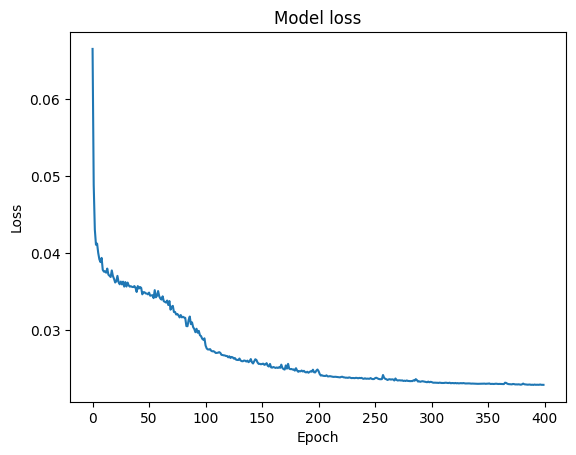

In [20]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [21]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

32/32 [==============================] - 3s 75ms/step


In [22]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [23]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 8.163466
C error per pixel [0, 255]: 3.0920541


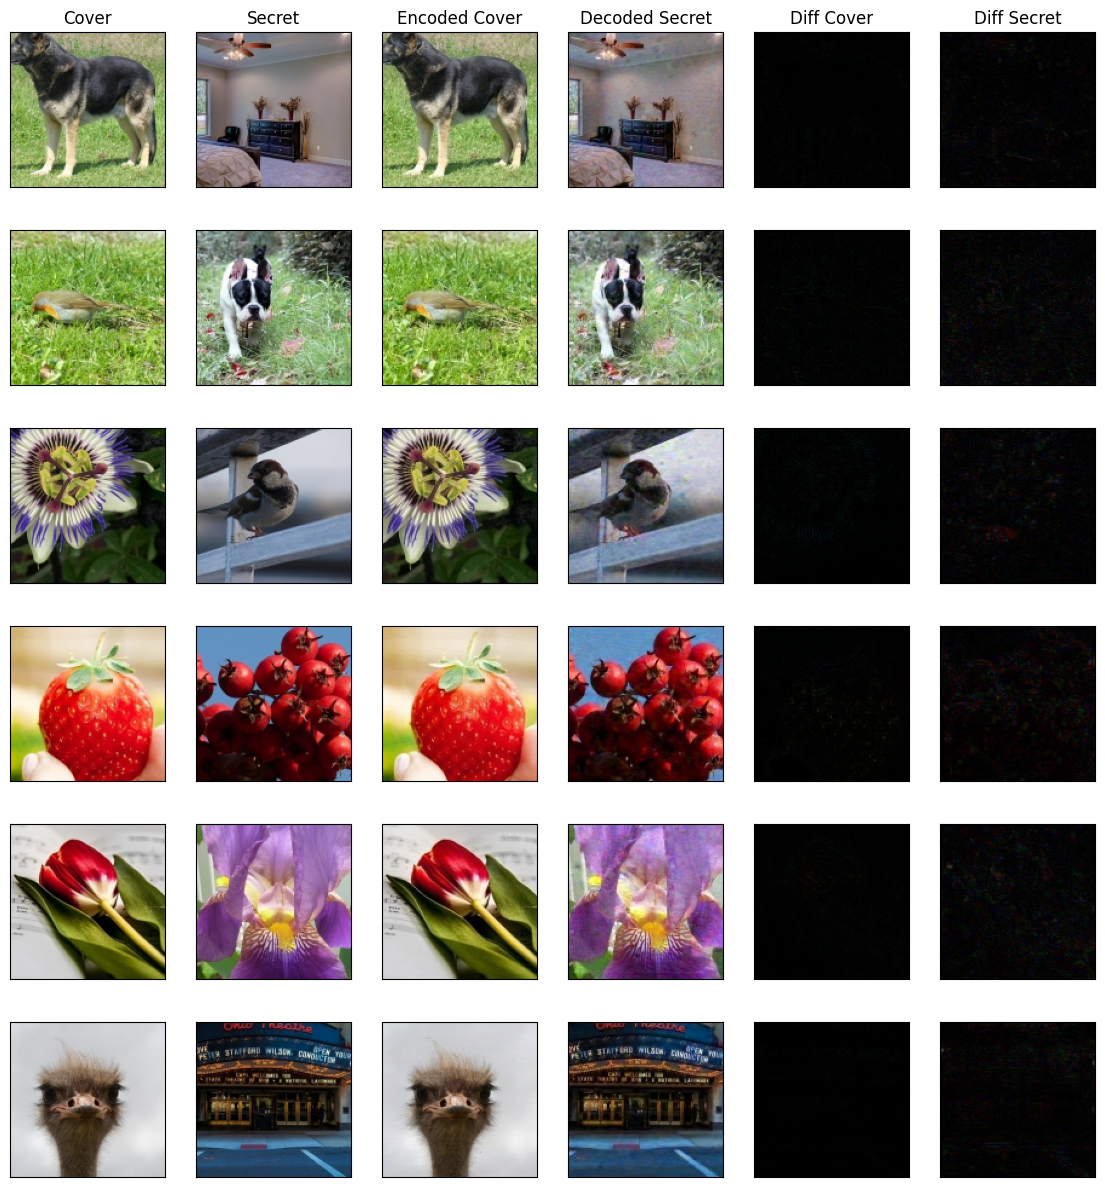

In [24]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()